# Demo Convolutional Neural Network (CNN o ConvNet) para clasificar Naves Imperiales de Star Wars (v2)

In [ ]:
#@title Librerías a usar
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import math

import os
import csv

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [ ]:
# @title Acceder al Drive {"single-column":true}

# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = '/content/gdrive/MyDrive/demosColab/demoStarWars/datos/'  #@param {type:"string"}


Mounted at /content/gdrive


In [ ]:
#@title Cargar datos

#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'naves.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}
separador_decimal = '.' #@param {type:"string"}

# funciones auxiliares

# importa datos
def cargarDatosDF(path, archivo_datos, delimitador_columnas, separador_decimal, mostrarEstadisticas=True):
  if os.path.isfile( path + '/' + archivo_datos ):
    # existe el archivo
    if ((delimitador_columnas is None) or (delimitador_columnas=="")):
      # si no se define asume ","
      delimitador_columnas = ","
    if ((separador_decimal is None) or (separador_decimal=="")):
      # si no se define asume "."
      separador_decimal = "."
    if (delimitador_columnas==separador_decimal):
      # ambos delimitadores iguales, cambia el decimal
      if delimitador_columnas == ",":
        separador_decimal = "."
      else:
        separador_decimal = ","
      print("- Ambos delimitadores configurados igual, se cambia separador decimal a '" + separador_decimal + "'!")
    # carga datos
    df = pd.read_csv(path + archivo_datos,
                     sep=delimitador_columnas, decimal=separador_decimal,
                     skip_blank_lines=True,
                     engine="python")
    print("> Archivo de datos", archivo_datos, "cargado")
    # muestra estadísticas
    if mostrarEstadisticas:
      print("\n> Cabecera: ")
      print(df.head())
      print("\n> Características: ")
      print(df.describe())
      print("\n")
    # controla que el archivo tenga sentido
    if len(df.columns.values.tolist())<2:
      print("\n> El archivo de datos debería tener al menos 2 columnas, revise delimitador de columnas!")
      return None
    else:
      return df
  else:
    print("No existe archivo de datos ", archivo_datos, "!")
    return None

# importa definición axiliar de las clases (si existe)
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    # si existe, carga los datos
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    # no encontrado
    return "", ""

# inicializa valores
X = None
Y = None

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## aplicación de los parámetros elegidos

# Carga los datos del CSV y muestra los primeros
df = cargarDatosDF(path, archivo_datos,
                   delimitador_columnas, separador_decimal, mostrarEstadisticas=True)

if df is not None:

  # intenta cargar configuración asociada a los datos
  # trata de obtener la configuración del archivo asociado
  atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

  # muestra interface para cargar configuración de los parámetros

  # función auxiliara para que no ejecute UI cada vez
  def hacerNada():
      return

  # se define esta función para que se ocupe de aplicar la configuración
  def on_buttonAplicar_clicked(b):
      print("")
      funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

  # aplica configuración de datos
  def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
      global Y, X, nombre_clases

      if (attClase is None) or (attClase =="") or\
        (att_entrada is None) or (att_entrada ==""):
        return

      # si el atributo clase está como de entrada, lo saca (no tiene sentido)
      att_entrada = list(att_entrada)
      if (attClase in att_entrada):
        print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
        att_entrada.remove( attClase )

      if (att_entrada == "") or (len(att_entrada)==0):
        print("No se han definido atributos de entrada!")
        return

      # guarda configuración
      nombre_clases = nomClases

      # genera los datos solo con los atributos seleccionados
      # para clase
      if (attClase in df):
        Y = np.array(df[attClase])
      else:
        print("Atributo " + attClase + " no encontrado !")
        X = None
        Y = None
        return
      # para entrada
      X = np.array(df[att_entrada])

      # muestra resultados
      print("\n> Atributos entrada: ", att_entrada)
      print("\t X: ", X.shape)

      if (nombre_clases is None) or (nombre_clases==""):
        print("\n> Atributo clase: ", attClase)
      else:
        print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
      print("\t Y: ", Y.shape)

  # auxiliar para que muestre bien la descripción
  style_3D = {'description_width': 'initial'}

  tit = widgets.Label("Ajuste para configuración de los Datos: ")

  # prepara combo para determinar atributo clase
  selecc_atributos = [ ]
  selecc_atributos.extend( df.columns.values.tolist() )
  if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
    att_selecc_defecto = len(selecc_atributos)-1
  else:
    att_selecc_defecto = selecc_atributos.index(atributo_clase)
  combo_att_clase = widgets.Dropdown(
      options = selecc_atributos,
      value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
      description = 'Atributo clase:',
      style=style_3D,
      disabled = False,
  )
  # prepara campo para ingresar nombre clases (toma por defecto de config)
  texto_nomClases = widgets.Text(
      value=nombre_clases,
      placeholder='Ingrese nombre clases (si corresponde) separados por comas',
      description='Nombre clases:',
      style=style_3D,
      disabled=False
  )

  combo_att_entrada = widgets.SelectMultiple(
      options=selecc_atributos,
      value=selecc_atributos,
      #rows=10,
      description='Atributos de entrada:',
      style=style_3D,
      disabled=False
  )

  # prepara botón y grilla con objetos
  btnAplicar = widgets.Button(
      description='Aplicar'
  )
  configDatos_ui = widgets.GridBox(
        children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
        layout=Layout(width='100%')  )
  btnAplicar.on_click(on_buttonAplicar_clicked)

  #clear_output()
  out_config = widgets.interactive_output(hacerNada, {})
  display(configDatos_ui)

  # ejecuta para que muestre
  on_buttonAplicar_clicked(btnAplicar)


> Archivo de datos naves.csv cargado

> Cabecera: 
   Manufacturer  Length  Crew  Troops  Cargo Capacity  Consumables  \
0          18.0    40.0   8.0    20.0        100000.0     3.000000   
1          18.0   153.0  12.0    10.0        200000.0     3.000000   
2          18.0     6.3   1.0     0.0            65.0     0.066667   
3          17.0     6.7   1.0     0.0            45.0     0.066667   
4          18.0     6.1   1.0     0.0            -1.0     0.033333   

   Hyperdrive Multiplier  Hyperdrive Backup  Speed   Hull  Shields  \
0                    2.0               12.0   65.0  112.0    200.0   
1                   -1.0               -1.0   78.0  285.0    400.0   
2                   -1.0               -1.0   95.0    9.0     -1.0   
3                   -1.0               -1.0   90.0    9.0     -1.0   
4                   -1.0               -1.0  111.0   16.0     -1.0   

   Special Features  Onboard Craft  QUAD LASER CANNON TURRETS  \
0          0.036667       0.016255        

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Ship Type como de entrada dado que es clase.

> Atributos entrada:  ['Manufacturer', 'Length', 'Crew', 'Troops', 'Cargo Capacity', 'Consumables', 'Hyperdrive Multiplier', 'Hyperdrive Backup', 'Speed', 'Hull', 'Shields', 'Special Features', 'Onboard Craft', 'QUAD LASER CANNON TURRETS', 'GENERAL PURPOSE LAUNCHERS', 'DOUBLE TURBOLASER CANNONS', 'LASER CANNONS', 'MEDIUM BLASTER CANNONS', 'LIGHT TURBOLASER CANNONS', 'CONCUSSION MISSILE LAUNCHERS', 'TURBOLASER BATTERIES', 'HEAVY TURBOLASER TURRETS', 'TURBOLASER CANNONS', 'BUILD-IN SPACE BOMB.', 'MEDIUM ION CANNONS', 'PROTON TORPEDO LAUNCHERS', 'QUAD LASER CANNONS', 'GRAVITY WELL PROJECTORS', 'QUAD TURBOLASER BATTERIES', 'DOUBLE TURBOLASER BATTERIES', 'CUNCUSSION MISSILE LAUNCHERS', 'TRACTOR BEAM PROJECTORS', 'DOUBLE LASER CANNONS', 'DOUBLE BLASTER CANNONS', 'TWIN LASER CANNONS', 'LASER CANNON TURRETS', 'MEDIUM TURBOLASERS', '(VARIES ACCORDING TO SHIP MODEL)', 'HEAVY BLASTER CANNONS', 'PROTON TORPEDOS', 'ORBITAL MINE OR T

In [ ]:
#@title Normalizar datos de entrada (opcional)

aplica_normalizacion = True #@param {type:"boolean"}
#@markdown Si se aplica, seleccione el tipo de método de normalización a aplicar:
tipo_normalizacion = "Standard Scaler" #@param ["Standard Scaler", "MinMax Scaler", "MaxAbs Scaler", "Robust Scaler"]

if aplica_normalizacion:

  print("10 primeros datos de Entrada antes de normalizar: ")
  print(X[:10])

  from sklearn import preprocessing

  # elegir el método de normalización
  if tipo_normalizacion == "Standard Scaler":
    scaler = preprocessing.StandardScaler()
  elif tipo_normalizacion == "MinMax Scaler":
    scaler = preprocessing.MinMaxScaler()
  elif tipo_normalizacion == "MaxMax Scaler":
    scaler = preprocessing.MaxAbsScaler()
  elif tipo_normalizacion == "Robust Scaler":
    scaler = preprocessing.RobustScaler()

  # normaliza los datos de entrada
  X = scaler.fit_transform(X)

  print("\n\n10 primeros datos de Entrada después de normalizar: ")
  print(X[:10])

10 primeros datos de Entrada antes de normalizar: 
[[ 18.   40.   65.  112.  200. ]
 [ 18.  153.   78.  285.  400. ]
 [ 18.    6.3  95.    9.   -1. ]
 [ 17.    6.7  90.    9.   -1. ]
 [ 18.    6.1 111.   16.   -1. ]
 [  3.   15.  122.   19.  120. ]
 [ 13.  180.   83.  176.  384. ]
 [ 12.  345.   26.  423.  900. ]
 [ 20.    8.7 144.   38.   -1. ]
 [  2.  153.   22.  188.  400. ]]


10 primeros datos de Entrada después de normalizar: 
[[ 0.47045026 -0.20882367 -0.10770292 -0.15391286 -0.15795694]
 [ 0.47045026 -0.15536682  0.22895947 -0.13435856 -0.14538968]
 [ 0.47045026 -0.22476611  0.66921028 -0.16555501 -0.17058703]
 [ 0.33100932 -0.22457688  0.53972474 -0.16555501 -0.17058703]
 [ 0.47045026 -0.22486072  1.08356398 -0.1647638  -0.17058703]
 [-1.62116378 -0.2206504   1.36843215 -0.1644247  -0.16298384]
 [-0.22675442 -0.14259395  0.358445   -0.1466789  -0.14639506]
 [-0.36619535 -0.0645375  -1.11769008 -0.11876033 -0.11397153]
 [ 0.74933213 -0.22363074  1.9381685  -0.16227712 -0.170587

In [ ]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "discreto - CLASIFICACION" #@param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100.0

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# inicializa listas
x_train, x_test, y_train, y_test = [], [], [], []
y_trainEnc, y_testEnc = [], []

# control aque haya datos definidos
assert (X is not None), "No se cargaron datos de atributos de entrada!"
assert (len(X)>0), "No se cargaron datos de atributos de entrada!"
assert (Y is not None), "No se cargaron datos de atributo clase!"
assert (len(Y)>0), "No se cargaron datos de atributo clase!"

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("** No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  ## CLASIFICAR
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
    # toma los valores de clase orginales del archivo
    if str(Y[0]).replace(".","").isnumeric():
      # Y son números
      print("-- Utiliza valores numéricos como clase.")
      for val in range(int(np.max(Y))+1):
        CLASES.append( "clase {:>3}".format(val) )
    else:
        # Y no son números
        print("-- Utiliza valores alfanuméricos como clase.")
        CLASES = list(set(Y))
        CLASES.sort()
        # cambia valores para que sean enteros
        y_train = [ CLASES.index(y) for y in y_train]
        y_test = [ CLASES.index(y) for y in y_test]
  else:
    # toma configuración de nombre de clases
    print("-- Utiliza nombres de clase definidos.")
    for val in nombre_clases.split(','):
      CLASES.append( val )

  # controla, con advertencias
  if len(CLASES) == 0:
    print("** No se encontraron clases!\n")
  elif len(CLASES) > 10:
    print("** Se detectaron más de 10 clases, revise los datos y el tipo de problema seleccionado!\n")
  # genera salida codificada para softMax
  y_trainEnc = to_categorical(y_train)
  y_testEnc = to_categorical(y_test)
  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES )
else:
  ## ESTIMAR
  print("> se considera problema de ESTIMACIÓN \n")
  if not(str(Y[0]).replace(".","").isnumeric()):
    print("-- Detecta valores alfanuméricos en atributo clase -> convierte a númerico:")
    CLASES = list(set(Y))
    CLASES.sort()
    # cambia valores para que sean enteros
    y_train = [ CLASES.index(y) for y in y_train]
    y_test = [ CLASES.index(y) for y in y_test]
    print(" - dictMapeo (", len(CLASES), "): ", [ str(i) + " : " +CLASES[i]  for i in range(len(CLASES)) ] )

# convierte a numpy para usar por modelo
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# muestra ejemplos
print("\n> Datos para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_train == i))

print("\n Datos para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    print("    ", CLASES[i], "[", i, "]:", np.sum(y_test == i))
print("")


> se considera problema de CLASIFICACIÓN 

-- Utiliza valores alfanuméricos como clase.
** Se detectaron más de 10 clases, revise los datos y el tipo de problema seleccionado!

> Definición de CLASES: 
 - dictMapeo ( 12 ):  ['Command Ships', 'Heavy Ships', 'Landing Craft', 'Medium Ships', 'Other Starfighters', 'Patrol Craft', 'Shuttles', 'TIE Bombers', 'TIE Experimental Craft', 'TIE Fighters', 'TIE Support Craft', 'Transporters']

> Datos para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (80, 5)
 - y_train (cant):  80
     Command Ships [ 0 ]: 2
     Heavy Ships [ 1 ]: 10
     Landing Craft [ 2 ]: 5
     Medium Ships [ 3 ]: 11
     Other Starfighters [ 4 ]: 8
     Patrol Craft [ 5 ]: 5
     Shuttles [ 6 ]: 5
     TIE Bombers [ 7 ]: 5
     TIE Experimental Craft [ 8 ]: 4
     TIE Fighters [ 9 ]: 15
     TIE Support Craft [ 10 ]: 7
     Transporters [ 11 ]: 3

 Datos para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (27, 5)
 - y_test (cant):  27
     Command Ships [

# Modelo:

In [ ]:
#@title Establecer modelo


#@markdown ### Parámetros de las capas ConvNet:
convNet_cantidad_capas =  2#@param {type:"integer"}
convNet_tipo_funcion = 'relu' #@param ['exponential', 'linear', 'relu', 'sigmoid', 'tanh' ]
convNet_kernel_tamaño_N =  1 #@param {type:"integer"}
convNet_pooling_tamaño_M = 1 #@param {type:"integer"}
convNet_pooling_tipo = 'Max-Pooling' #@param ["Max-Pooling", "Avg_Pooling"]
convNet_reshape_lineal = 'Flatten' #param ["Flatten", "GlobalAveragePooling"]

#@markdown ### Parámetros de las capas Lineales:
lineal_cant_neuronas_capas_ocultas = '32, 16' #@param {type:"string"}
lineal_tipo_funcion = 'relu' #@param ['exponential', 'linear', 'relu', 'sigmoid', 'tanh' ]
#markdown (Nota: se puede indicar Cantidad de neuronas, D para DropOut, BN para BatchNormalization)
lineal_porc_capa_DropOut = 0.3 #param {type:"number"}
rna_tipo_capa_salida = 'softmax-MultiClase' #@param ["identidad-Numero", "softmax-MultiClase"]

#@markdown ### Parámetros del Optimizador:
opt_tipo = "Adam" #@param ["Gradiente Decreciente", "Adam", "Adadelta", "Adagrad", "Adamax", "RMSprop", "Momentum", "NAG", "Nadam"]
opt_learning_rate = 0.001 #@param {type: "number"}

## controla los parámetros elegidos

# define si el tipo de capa de salida es softmax( True )  o lineal ( False )
# esto implica también cambiar cómo se codifican los valores de las clases a usar
if esProblemaClasificacion:
  tipo_output_softMax = (rna_tipo_capa_salida[:7] == 'softmax')
else:
  print("-- se considera salida lineal porque es problema de Estimación!")
  tipo_output_softMax = False


### funciones auxiliares para crear modelo ###

# agrega capa entrada
def agregarCapaEntrada(num_inputs):
  return tf.keras.layers.Input(shape=(num_inputs,), name='input')

# agrega capas Conv2D + MaxPooling
def agregarCapasConvolucionalesDatos(eachLay, cant_capas, tipo_funcion="relu", kernel_shape_N=1, pooling_shape_M=1, pooling_type="M", reshape_type="F"):
  # controla cantidad de capas cnn
  if cant_capas<1:
    # si cantidad menor que 1 no agrega
    print("No se agregan capas convolucionales!")
    return eachLay
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # valida kernel y pool shape
  cnn_kernel_shape = ( max(kernel_shape_N, 1) )
  cnn_pooling_shape = ( max(pooling_shape_M, 1) )
  # determina pool type
  if pooling_type == 'A':
    cnn_pooling_type = tf.keras.layers.AveragePooling1D
  else:
    cnn_pooling_type = tf.keras.layers.MaxPooling1D
  #  agrega capa Reshape para poder procesar datos lineales  por capas convolucionales
  if len(eachLay.shape)>0:
    num_inputs = eachLay.shape[1]
    matrixShape = None
    for val in [2, 3, 5, 7, 11]:
      if (num_inputs%val)==0:
        matrixShape = [val,(num_inputs//val)]
        break
    if matrixShape is None:
      matrixShape = [1, num_inputs]
    eachLay = tf.keras.layers.Reshape(matrixShape, name="reshape_input" )(eachLay)
  # agrega capas convolucionales
  auxId = 0
  for i in range(cant_capas, 0, -1):
      # define automática cantidad de filtros
      # para que decrementen por capa según recomendación
      cnn_filters =  2**(i+2)
      # define el nombre de la capa oculta
      auxId += 1
      auxlayerName = 'conv_'+str(auxId)
      # agrega las capas ocultas de tipo Conv2D + MaxPooling
      eachLay =  tf.keras.layers.Conv1D(cnn_filters,
                                        cnn_kernel_shape,
                                        activation=tipo_funcion,
                                        padding='same',
                                        name=auxlayerName+'_cf')(eachLay)
      # determina nombre y shape de la capa conv2D
      last_conv_layer_name = 'c_'+auxlayerName
      last_conv_layer_shape = (eachLay.shape[1], eachLay.shape[2])
      ##print(last_conv_layer_name, last_conv_layer_shape, eachLay.shape)
      eachLay =  cnn_pooling_type(cnn_pooling_shape,
                                 padding='same',
                                 name=auxlayerName+'_p')(eachLay)
  # agrega capa reshape a vector
  if reshape_type == "G":
    #  agrega capa GlobalAveragePooling2D
    eachLay = tf.keras.layers.GlobalAveragePooling1D(name='flat_GAP')(eachLay)
  else:
    #  agrega capa Flatten
    eachLay = tf.keras.layers.Flatten(name='flat')(eachLay)
  # devuelve última
  return eachLay


# agrega capas lineales (Dense, DO, BN) según configuración
def agregarCapasLineales(eachLay, configCapasList, tipo_funcion="relu", porc_capa_DropOut=0.1):
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # chequea configuración de drop out
  lineal_porc_capa_DropOut = min(max(0.1, porc_capa_DropOut), 0.9)
  # recorre lista de configuración
  auxId = 1
  for val_hid in configCapasList:
    # saca espacios por las dudas
    val_hid = val_hid.strip()
    # evalúa
    if val_hid.upper() == "D":
      # agrega Drop-Out
      auxlayerName = "d_"+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.Dropout(porc_capa_DropOut,
                                        name=auxlayerName)(eachLay)
    elif val_hid.upper() == "BN":
      # agrega BatchNormalization
      auxlayerName = "bn_"+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.BatchNormalization(name=auxlayerName)(eachLay)
    elif val_hid.isnumeric():
      # agrega Dense (MLP)
      auxlayerName = 'hidd_'+str(auxId)
      auxId = auxId + 1
      eachLay = tf.keras.layers.Dense(int(val_hid), activation=tipo_funcion,
                                      name=auxlayerName)(eachLay)
    else:
      # otras
      print("Tipo capa configurada", val_hid, "descartada!")
  #devuelve última capa
  return eachLay


# agrega capa salida con configuración del modelo (loss y metrics para modelo)
def agregarCapaSalida(eachLay, esProblemaClasificacion, usarSoftMax=False, cantClases=1):
  # valida capa anterior
  assert eachLay is not None, "Capa anterior no definida!"
  # determina capa de salida,
  if esProblemaClasificacion:
    # métrica para clasificación
    metricsType= ['accuracy']
    if usarSoftMax:
        # capa de salida softmax
        output_Lay = tf.keras.layers.Dense(units=cantClases, activation='softmax', name='output')(eachLay)
        # utiliza un loss de multiple clases
        lossType = 'categorical_crossentropy'
    else:
        # capa de salida lineal
        output_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay)
        # utiliza un loss de valor numérico
        lossType = 'mse'
  else:
    # capa de salida lineal
    output_Lay = tf.keras.layers.Dense(1, activation=None, name='output')(eachLay)
    # métrica para estimación
    metricsType=['RootMeanSquaredError']
    # utiliza un loss de valor numérico
    lossType = 'mse'
  return output_Lay, metricsType, lossType

# define algoritmo de optimización
def definirOpt(opt_tipo, opt_learning_rate=0.01):
  # chequea configuracion LR
  opt_learning_rate = min(max(0.00001, opt_learning_rate), 10)
  # determina algoritmo de optimización
  if opt_tipo == "Gradiente Decreciente":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adam":
    opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adadelta":
    opt = keras.optimizers.Adadelta(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adagrad":
    opt = keras.optimizers.Adagrad(learning_rate=opt_learning_rate)
  elif opt_tipo == "Adamax":
    opt = keras.optimizers.Adamax(learning_rate=opt_learning_rate)
  elif opt_tipo == "Nadam":
    opt = keras.optimizers.Nadam(learning_rate=opt_learning_rate)
  elif opt_tipo == "RMSprop":
    opt = keras.optimizers.RMSprop(learning_rate=opt_learning_rate)
  elif opt_tipo == "Momentum":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate, momentum=0.9, nesterov=False)
  elif opt_tipo == "NAG":
    opt = keras.optimizers.SGD(learning_rate=opt_learning_rate, momentum=0.9, nesterov=True)
  else:
    # por defecto usa ADAM
    opt = keras.optimizers.Adam(learning_rate=opt_learning_rate)
  return opt


### fin funciones auxiliares para crear modelo ###


## construye la ConvNet
# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente

# capa de entrada en base a tamaño de datos de entrada
input_Lay = agregarCapaEntrada(num_inputs=x_train.shape[1])
eachLay = input_Lay

# capas ocultas convolucionales
eachLay = agregarCapasConvolucionalesDatos(eachLay,
                                      cant_capas=max(convNet_cantidad_capas, 1),
                                      tipo_funcion=convNet_tipo_funcion,
                                      kernel_shape_N=convNet_kernel_tamaño_N,
                                      pooling_shape_M=convNet_pooling_tamaño_M,
                                      pooling_type=convNet_pooling_tipo.upper()[0],
                                      reshape_type=convNet_reshape_lineal.upper()[0])

# capas ocultas lineales
eachLay = agregarCapasLineales(eachLay,
                               configCapasList=lineal_cant_neuronas_capas_ocultas.split(','),
                               tipo_funcion=lineal_tipo_funcion,
                               porc_capa_DropOut=lineal_porc_capa_DropOut)

# capa salida
output_Lay, metricsType, lossType = agregarCapaSalida(eachLay,
                                                      esProblemaClasificacion=esProblemaClasificacion,
                                                      usarSoftMax=tipo_output_softMax,
                                                      cantClases=len(CLASES))

# determina optimizador
optModel = definirOpt(opt_tipo=opt_tipo,
                      opt_learning_rate=opt_learning_rate)

# genera el modelo RNA MLP Backpropagation
model = Model(input_Lay, output_Lay, name='ConvNet')
model.compile(optimizer=optModel, loss=lossType, metrics=metricsType)

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")


Modelo creado con  10  capas:


Model: "ConvNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_input (Reshape)         │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_cf (Conv1D)              │ (None, 5, 16)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1_p (MaxPooling1D)         │ (None, 5, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_cf (Conv1D)              │ (None, 5, 8)           │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2_p (MaxPooling1D)         │ (None, 5, 8)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat (Flatten)                  │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_1 (Dense)                  │ (None, 32)             │         1,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidd_2 (Dense)                  │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,212 (8.64 KB)

 Trainable params: 2,212 (8.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

#@title Visualizar modelo

mostrar_modelo = False #@param {type:"boolean"}
if mostrar_modelo:
  if  (model is None):
    print("Modelo no disponible.")
  else:
    print("Modelo creado con ", len(model.layers), " capas:")
    display(plot_model(model, show_layer_names=True, show_shapes=True))



In [ ]:
#@title Entrenar modelo

cant_epocas_entrenamiento = 250 #@param {type:"integer"}
porcentaje_datos_validacion = 5 #@param {type:"number"}

#@markdown Configración para Early Stopping:
activar_corte_por_estabilidad_val_loss = True #@param {type:"boolean"}
epoca_comienza_monitorear_estabilidad = 50 #@param {type:"integer"}
min_cambio_val_loss_considera_mejora = 0.001 #@param {type:"number"}
epocas_paciencia_estabilidad = 25 #@param {type:"integer"}
devolver_pesos = "Mejores" #@param ["Mejores", "Ultimos"]


## controla parámetros

# controla cantida de épocas
cantEpocas = max(1,cant_epocas_entrenamiento)

# controla porcentaje de validación
porcentaje_datos_validacion = min(49.9, porcentaje_datos_validacion)
porcentaje_datos_validacion = max(0.5, porcentaje_datos_validacion)

print("\n> De los ", len(x_train), "ejemplos de entrenamiento se toma " + str(round((100-porcentaje_datos_validacion), 1)) + "% para entrenar y " + str(round(porcentaje_datos_validacion, 1)) + "% para validar. ")

# controla capa de entrada vs datos de entrada para entrenamiento
assert len(model.input.shape)==len(x_train.shape), "* La forma de la capa de entrada NO es igual a la de los datos de entrada! : " + str(model.input.shape) + " != " + str(x_train.shape)
for i in range(1, len(model.input.shape)):
  assert model.input.shape[i]==x_train.shape[i], "* La forma de la capa de entrada NO es igual a la de los datos de entrada! : " + str(model.input.shape[i]) + " != " + str(x_train.shape[i])

# controla capa de salida vs datos de salida para entrenamiento
if tipo_output_softMax:
  assert len(model.output.shape)>=len(y_trainEnc.shape), "* La forma de la capa de salida softmax NO es igual a la de los datos de salida encoded! : " + str(model.output.shape) + " != " + str(y_trainEnc.shape)
  for i in range(1, len(model.output.shape)):
    assert model.output.shape[i]==y_trainEnc.shape[i], "* La forma de la capa de salida softmax NO es igual a la de los datos de salida encoded! : " + str(model.output.shape[i]) + " != " + str(y_trainEnc.shape[i])
else:
  # nota y_train puede tener una dimensión menos que outpout shape para datos lineales
  assert len(model.output.shape)>=len(y_train.shape), "* La forma de la capa de salida lineal NO es igual a la de los datos de salida! : " + str(model.output.shape) + " != " + str(y_train.shape)
  for i in range(1, len(y_train.shape)):
    assert model.output.shape[i]==y_trainEnc.shape[i], "* La forma de la capa de salida lineal NO es igual a la de los datos de salida! : " + str(model.output.shape[i]) + " != " + str(y_train.shape[i])

# configura ealy stopping
callbacksList = []
if activar_corte_por_estabilidad_val_loss:
  # válida parámetros de early stopping
  min_cambio_val_loss_considera_mejora = max(0, min_cambio_val_loss_considera_mejora)
  epocas_paciencia_estabilidad = max(1, epocas_paciencia_estabilidad)
  epoca_comienza_monitorear_estabilidad = max(2, epoca_comienza_monitorear_estabilidad)

  # se agrega un callBack para que corte
  # si el error de validación no sigue bajando
  early_stopping_monitor = keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=min_cambio_val_loss_considera_mejora,
      patience=epocas_paciencia_estabilidad,
      verbose=1,
      mode='min',
      baseline=None,
      restore_best_weights=(devolver_pesos == "Mejores"),
      start_from_epoch=epoca_comienza_monitorear_estabilidad
  )
  callbacksList = [early_stopping_monitor]
  print("\n> Se activa Early Stopping.")

# determina la época en que se activo early stopping
# (si se uso y terminó antes)
def getEarlyStoppingEppoch(callbacksList):
  if callbacksList is not None:
    for earlyStopCB in callbacksList:
      if isinstance(earlyStopCB, keras.callbacks.EarlyStopping):
        if earlyStopCB.restore_best_weights:
          # si restaura mejor
          if (earlyStopCB.best_epoch>0):
            # se detuvo por early stopping, devuelve la época correspondiente
            return earlyStopCB.best_epoch+1
        else:
         if (earlyStopCB.stopped_epoch>0):
            # se detuvo por early stopping, devuelve la época correspondiente
            return earlyStopCB.stopped_epoch+1
  return None

# registra tiempo proceso comienzo
import time
start_process_time = time.process_time()

print("\n\n> Comienza el Entrenamiento:")

# lleva a cabo el entrenamiento
history = model.fit(x=x_train,
                    y = y_trainEnc if tipo_output_softMax else y_train,
                    epochs = cantEpocas,
                    validation_split=porcentaje_datos_validacion/100.0,
                    callbacks=callbacksList)

# registra tiempo fin y duración
process_duration = time.process_time() - start_process_time

if process_duration>60:
  print(f"\n> Entrenamiento Finalizado: {process_duration/60.0:.3f} minutos.")
else:
  print(f"\n> Entrenamiento Finalizado: {process_duration:.3f} segundos.")

# identifca epoch que terminó early stopping (o None)
epoch_earlyStopping = getEarlyStoppingEppoch(callbacksList)




> De los  80 ejemplos de entrenamiento se toma 95% para entrenar y 5% para validar. 

> Se activa Early Stopping.


> Comienza el Entrenamiento:
Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.0800 - loss: 2.4830 - val_accuracy: 0.0000e+00 - val_loss: 2.4874
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2251 - loss: 2.4672 - val_accuracy: 0.0000e+00 - val_loss: 2.4860
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2290 - loss: 2.4570 - val_accuracy: 0.0000e+00 - val_loss: 2.4842
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2134 - loss: 2.4496 - val_accuracy: 0.0000e+00 - val_loss: 2.4827
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2173 - loss: 2.4404 - val_accuracy: 0.0000e+00 - val_loss: 2.4799
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3220 - loss: 2.4267 - val_accuracy: 0.2500 - val_loss: 2.4761
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3493 - loss: 

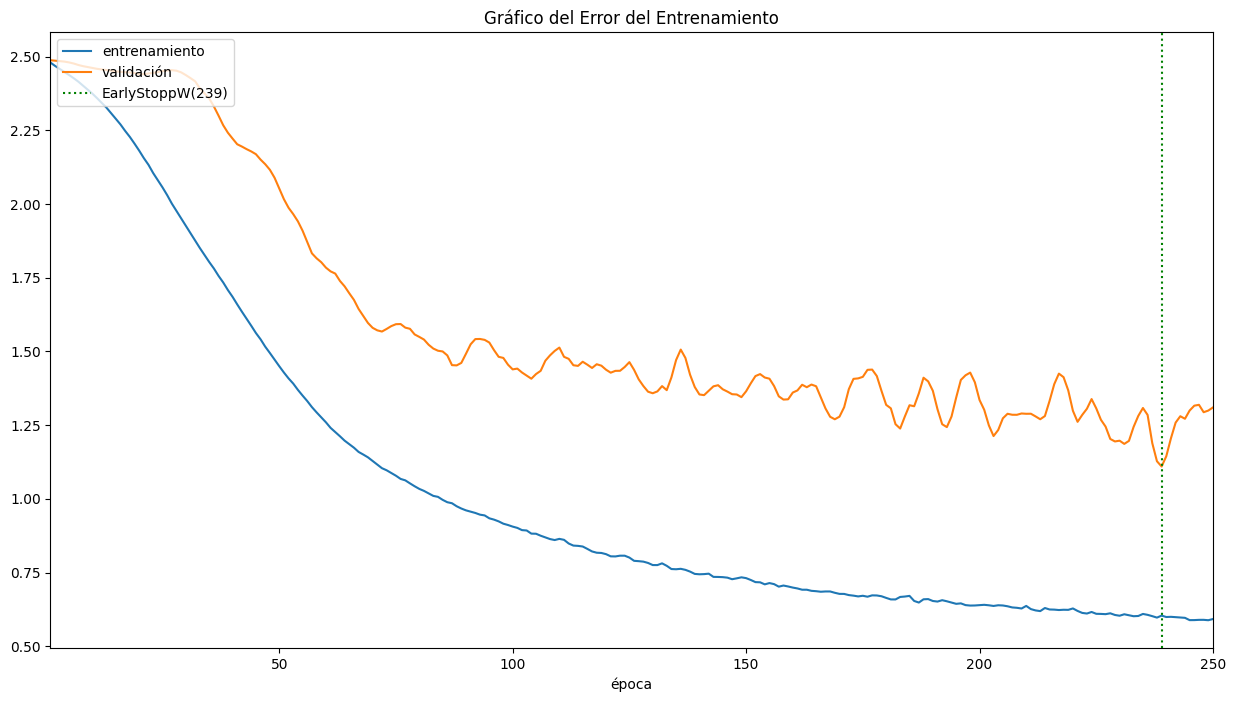

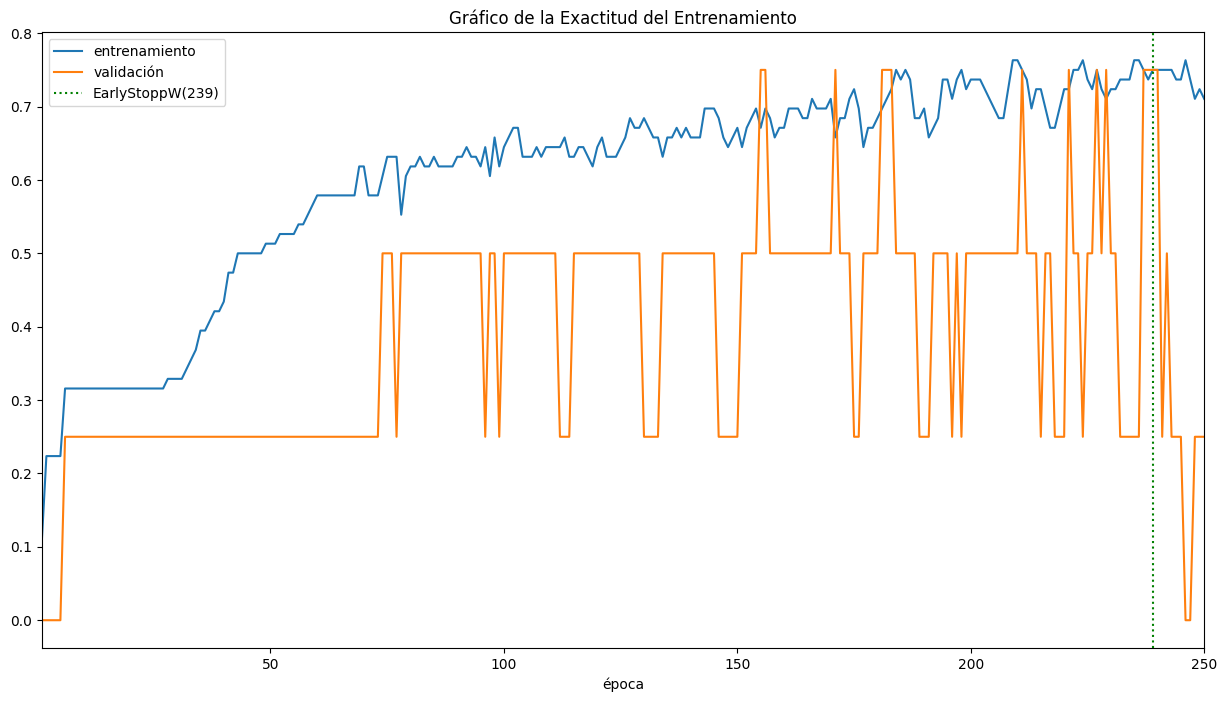

In [ ]:
#@title Mostrar Gráficos del Entrenamiento

# gráfico de LOSS
plt.figure(figsize=(15,8))
plt.plot([None] + history.history['loss']) # agrega valor None para epoch 0
plt.plot([None] + history.history['val_loss']) # agrega valor None para epoch 0
legendsLabels = ['entrenamiento', 'validación']
plt.ylabel('')
plt.xlabel('época')
plt.title('Gráfico del Error del Entrenamiento')
# resalta época de early_stopping_monitor (si se detuvo antes)
if epoch_earlyStopping is not None:
  esLabel = "EarlyStoppW("+str(epoch_earlyStopping)+")"
  plt.axvline(x=epoch_earlyStopping, color='g', linestyle=':', label=esLabel)
  legendsLabels.append( esLabel )

plt.legend(legendsLabels, loc='upper left')
plt.margins(x=0) # para que arranque en eje de coordenadas
plt.show()

# gráfico de MÉTRICAS
plt.figure(figsize=(15,8))
if esProblemaClasificacion:
  plt.plot([None] + history.history['accuracy']) # agrega valor None para epoch 0
  plt.plot([None] + history.history['val_accuracy']) # agrega valor None para epoch 0
  plt.title('Gráfico de la Exactitud del Entrenamiento')
else:
  plt.plot([None] + history.history['RootMeanSquaredError']) # agrega valor None para epoch 0
  plt.plot([None] + history.history['val_RootMeanSquaredError']) # agrega valor None para epoch 0
  plt.title('Gráfico de la Distancia Media Cuadrática Mínima del Entrenamiento')
legendsLabels = ['entrenamiento', 'validación']
plt.ylabel('')
plt.xlabel('época')
# resalta época de early_stopping_monitor (si se detuvo antes)
if epoch_earlyStopping is not None:
  plt.axvline(x=epoch_earlyStopping, color='g', linestyle=':')
  legendsLabels.append( esLabel )
plt.legend(legendsLabels, loc='upper left')
plt.margins(x=0)
plt.show()

### Evaluación del Modelo:

*** Resultados con datos de Entrenamiento: 

 Reporte de Clasificación: 
                        precision    recall  f1-score   support

         Command Ships       1.00      1.00      1.00         2
           Heavy Ships       1.00      1.00      1.00        10
         Landing Craft       0.75      0.60      0.67         5
          Medium Ships       1.00      0.91      0.95        11
    Other Starfighters       0.86      0.75      0.80         8
          Patrol Craft       0.33      0.20      0.25         5
              Shuttles       0.62      1.00      0.77         5
           TIE Bombers       0.00      0.00      0.00         5
TIE Experimental Craft       0.75      0.75      0.75         4
          TIE Fighters       0.72      0.87      0.79        15
     TIE Support Craft       0.45      0.71      0.56         7
          Transporters       1.00      0.67      0.80         3

              accuracy                           0.75        80
             macro avg       

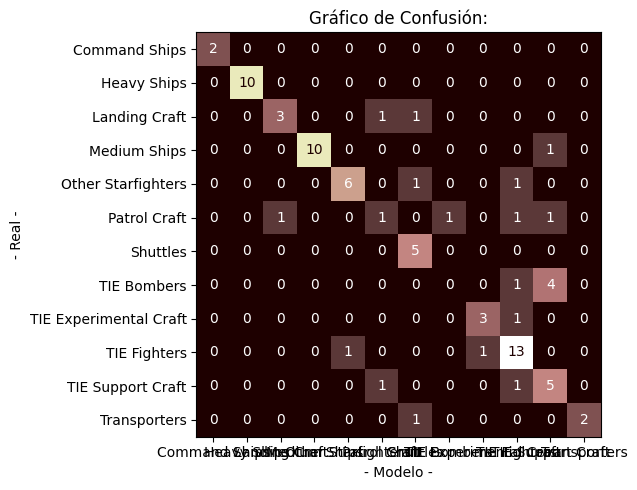

In [ ]:
#@title Evaluar con datos de entrenamiento

umbral_clasificacion = 50 #@param {type:"slider", min:1, max:99, step:1}
#@markdown ('umbral_clasificacion' sólo se usa para clasificación con salida lineal)
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}

# genera gráfico de los errores para Estimación
def generaResumen_Estimacion(ar, tit, b=10, c=None):
    # muestra resumen
    print("\n Estadísticas para " + tit + ": ")
    print("            Mínimo: {:.4f} ".format(np.min(ar)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(ar), np.std(ar)) )
    print("            Máximo: {:.4f} ".format(np.max(ar)) )
    # muestra gráfico
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()
    return

# función auxiliar para probar el modelo entrenado para Estimación
def analizarModelo_Estimacion(datosX, datosY, predsY, mostrarDetalle=False, inclDatosEntrada=False):
    # muestra títulos
    if mostrarDetalle:
      if inclDatosEntrada:
        print(" Datos ->", end="")
      print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")
    # procesa
    arAbs = []
    arRel = []
    for x, r, pV in zip(datosX, datosY, predsY):
      # toma el valor estimado/predecido
      p = interpretarPredsModelo(pV, esProblemaClasificacion=False)
      # controla que sean números
      if not(math.isnan(r) or math.isnan(p)):
        # hace los cálculos
        eAbs = abs(r - p)
        if r == 0:
          eRel = (eAbs / 1)*100.0
        else:
          eRel = (eAbs / r)*100.0
        # agrega a lista para estadística
        arAbs.append(eAbs)
        arRel.append(eRel)
        # muestra
        if mostrarDetalle:
          if inclDatosEntrada:
            print(" " + str(x) + "->", end="")
          print(" R: {:>10.4f} / M: {:>10.4f} [ {:>10.4f} | {:>10.2f}% ]".format(r, p, eAbs, eRel))
      else:
        # muestra inválidis
        if mostrarDetalle:
          if inclDatosEntrada:
            print(" " + str(x) + "->", end="")
          print(" descarta valores inválidos R: ", r," / M: ", p, "!")
    # muestra estadísticas de métricas
    generaResumen_Estimacion(arAbs, "Error Absoluto", 20, "red")
    generaResumen_Estimacion(arRel, "Error Relativo", 10, "magenta")
    return

def generaResumen_Clasificacion(classReal, classPreds, clases_labels):
    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds, zero_division=0))
    # muestra matriz de confusion
    print('\nMatriz de Confusión ( real / modelo ): ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_labels)
    cmtx = pd.DataFrame(
        cm,
        index=['r:{:}'.format(x) for x in clases_labels],
        columns=['m:{:}'.format(x) for x in clases_labels]
      )
    # agrega para poder mostrar la matrix de confusión completa
    pd.options.display.max_rows = 100
    pd.options.display.max_columns = 100
    cmtx.sort_index(axis=0, inplace=True)
    cmtx.sort_index(axis=1, inplace=True)
    print(cmtx)
    print("\n")
    # gráfico de comparación
    dispCM = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=clases_labels)
    fig, ax = plt.subplots(figsize=(15,5))
    dispCM.plot(ax=ax, cmap=plt.cm.pink, values_format='g', colorbar=False)
    dispCM.ax_.set_title('Gráfico de Confusión:')
    dispCM.ax_.set(xlabel='- Modelo -', ylabel='- Real -')
    plt.tight_layout()
    plt.show()
    return

# función auxiliar para probar el modelo entrenado en detalle
def analizarModelo_Clasificacion(datosX, datosY, predsY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, mostrarDetalle=False, inclDatosEntrada=False):
    # hace copia de classMap por si hay clases inválidas
    if clases_map is None:
      dict_clases_map = {}
    else:
      dict_clases_map = dict(enumerate(clases_map))
    # muestra títulos
    if mostrarDetalle:
      if inclDatosEntrada:
        print("  Datos Entrada -> Clase Real / Clase Modelo [resultado]")
      else:
        print(" Clase Real / Clase Modelo [resultado]")
    # procesa
    classPreds = []
    classReal = []
    for x, rId, pV in zip(datosX, datosY, predsY):
      # determina nombre clase real (agrega si no existe)
      clReal, dict_clases_map = asignarClassName(rId, dict_clases_map)
      # determina el ID de clase predecida
      pId = interpretarPredsModelo(pV, esProblemaClasificacion=True,
                                  tipo_output_softMax=tipo_output_softMax, umbralClas=umbralClas)
      # asigna nombre de clase (agrega si no existe)
      clPred, dict_clases_map = asignarClassName(pId, dict_clases_map)
      # agrega a listas
      classReal.append( clReal )
      classPreds.append( clPred )
      # muestra
      if mostrarDetalle:
        strCompara = "  "
        if inclDatosEntrada:
          strCompara = strCompara + str(x) + '-> '
        strCompara = strCompara +" R: {} [{}] / M: {} {}".format(clReal, rId, clPred, pV)
        strCompara = strCompara + " -> " + ("OK" if (clPred==clReal) else "ERROR!") + " "
        print(strCompara)
    # define lista de valores de clases
    clases_labels = list(dict_clases_map.values())
    # muestra matrices resumen
    generaResumen_Clasificacion(classReal, classPreds, clases_labels)
    return

# función que asigna nombre de clase en base a Id
# (si no existe lo agrega)
def asignarClassName(classId, dict_clases_map):
  if (classId in dict_clases_map):
    # nombre existe
    clName = dict_clases_map[classId]
  else:
    # nombre no existe, agrega
    clName = "CLASE " + str(classId) + " INVÁLIDA"
    dict_clases_map[classId] = clName
  # devuelve
  return clName, dict_clases_map

# función que interpreta resultados modelo
# de acuerdo a tipo de problem y configuración de clases
def interpretarPredsModelo(predY, esProblemaClasificacion, tipo_output_softMax=False, umbralClas=0.5):
  if esProblemaClasificacion:
    # CLASIFICACIÓN
    if tipo_output_softMax:
      ## salida SOFTMAX: determina clase predecida de acuerdo a la que tiene mayor valor
      pId = int( np.argmax(predY, axis=0) )
    else:
      ## salida SOFTMAX: determina clase predecida de acuerdo al umbral de clasificación
      auxId = predY[0]
      pId = int(auxId)
      auxRnd = abs(auxId - pId)
      if (auxRnd>umbralClas):
        # aplica umbral de clasificación
        pId += 1
    # devuelve Id de clase correspondiente
    return pId
  else:
    # ESTIMACIÓN: devuelve primer valor (RNA devuelve lista valores)
    return predY[0]

# método general para evaluar modelo
def evaluarModelo(modelo, esProblemaClasificacion, datosX, datosY, clases_map=None, tipo_output_softMax=False, umbralClas=0.5, mostrarDetalle=False, inclDatosEntrada=False):
    # procesa los datos de entrada con el modelo
    predsY = modelo.predict(datosX, verbose=0)
    # muestra resultados
    if esProblemaClasificacion:
      analizarModelo_Clasificacion(datosX, datosY, predsY,
                                   clases_map=clases_map, umbralClas=umbralClas,
                                   tipo_output_softMax=tipo_output_softMax,
                                   mostrarDetalle=mostrarDetalle, inclDatosEntrada=inclDatosEntrada)
    else:
      analizarModelo_Estimacion(datosX, datosY, predsY,
                                 mostrarDetalle=mostrarDetalle, inclDatosEntrada=inclDatosEntrada)

    return

# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
evaluarModelo(model, esProblemaClasificacion,
              datosX=x_train, datosY=y_train, clases_map=CLASES,
              tipo_output_softMax=tipo_output_softMax,
              umbralClas=umbral_clasificacion/100.0,
              mostrarDetalle=mostrar_detalle_entrenamiento,
              inclDatosEntrada=incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 

 Reporte de Clasificación: 
                        precision    recall  f1-score   support

         Command Ships       0.00      0.00      0.00         1
           Heavy Ships       0.80      1.00      0.89         4
         Landing Craft       0.50      1.00      0.67         2
          Medium Ships       0.67      0.50      0.57         4
    Other Starfighters       0.50      1.00      0.67         2
          Patrol Craft       0.00      0.00      0.00         2
              Shuttles       1.00      1.00      1.00         1
           TIE Bombers       0.00      0.00      0.00         1
TIE Experimental Craft       0.00      0.00      0.00         1
          TIE Fighters       0.50      0.80      0.62         5
     TIE Support Craft       0.00      0.00      0.00         3
          Transporters       1.00      1.00      1.00         1

              accuracy                           0.59        27
             macro avg       0.41 

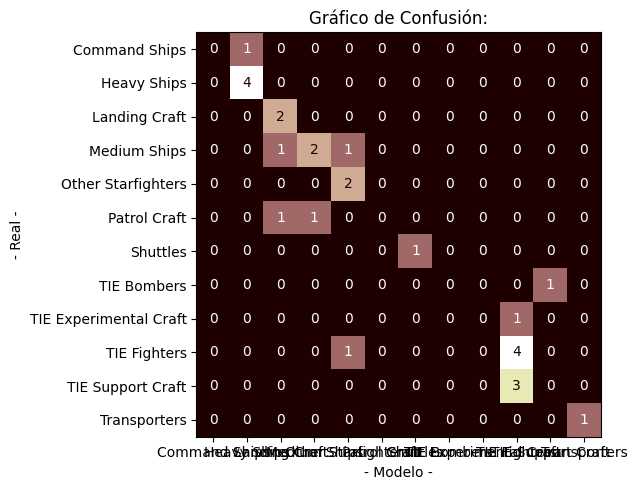

In [ ]:
#@title Evaluar con datos de prueba
mostrar_detalle_prueba = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = False #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
# muestra resultados
evaluarModelo(model, esProblemaClasificacion,
              datosX=x_test, datosY=y_test, clases_map=CLASES,
              tipo_output_softMax=tipo_output_softMax,
              umbralClas=umbral_clasificacion/100.0,
              mostrarDetalle=mostrar_detalle_prueba,
              inclDatosEntrada=incluirDatosEntrada_detalle_prueba)


### Exportar el Modelo:

In [ ]:
#@title Guardar Modelo entrenado

guardar_modelo = True #@param{type:"boolean"}
path_modelo = '/content/gdrive/MyDrive/demosColab/demoStarWars/modelos/datosConvNetV2'  #@param {type:"string"}

if guardar_modelo:

    import os

    # si no existe el directorio, lo crea
    if not os.path.isdir(path_modelo):
      os.makedirs(path_modelo)

    # guarda el modelo entrenado
    fn_model = path_modelo+"/model.keras"
    model.save(fn_model)
    print("\n-Modelo guardado en ", fn_model,"\n")

    if ("scaler" in locals()) and (scaler is not None):
      fn_scaler = path_modelo+"/SCALER.joblib"
      import joblib
      joblib.dump(scaler, fn_scaler)
      print("\n-SCALER para normalizar datos de entrada guardado en ", fn_scaler,"\n")

    if ("CLASES" in locals()) and (CLASES is not None):
      fn_clases = path_modelo+"/CLASES_MAP.txt"
      with open(fn_clases, 'w') as f:
        for i in range(len(CLASES)):
          f.write(str(i)+":"+str(CLASES[i])+"\n")
      print("\n-CLASES_MAP para mostrar los resultados guardado en ", fn_clases,"\n")

else:
    print("\n-Modelo no guardado.")


-Modelo guardado en  /content/gdrive/MyDrive/demosColab/demoStarWars/modelos/datosConvNetV2/model.keras 


-SCALER para normalizar datos de entrada guardado en  /content/gdrive/MyDrive/demosColab/demoStarWars/modelos/datosConvNetV2/SCALER.joblib 


-CLASES_MAP para mostrar los resultados guardado en  /content/gdrive/MyDrive/demosColab/demoStarWars/modelos/datosConvNetV2/CLASES_MAP.txt 

